In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
 !pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [3]:
import json
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer
from transformers import BertTokenizerFast
from datasets import Dataset
from sklearn.model_selection import train_test_split
import re
#from bert_score import score
from transformers import GPT2Tokenizer
from transformers import TFGPT2LMHeadModel,create_optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from transformers import TFGPT2LMHeadModel, GPT2TokenizerFast
from datasets import Dataset, DatasetDict
from datasets import load_dataset


2025-06-22 18:10:42.411951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750615842.883407      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750615843.009628      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
finance = load_dataset("virattt/financial-qa-10K")

README.md:   0%|          | 0.00/419 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [5]:
finance

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [6]:
finance['train'][0]

{'question': 'What area did NVIDIA initially focus on before expanding to other computationally intensive fields?',
 'answer': 'NVIDIA initially focused on PC graphics.',
 'context': 'Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.',
 'ticker': 'NVDA',
 'filing': '2023_10K'}

In [7]:
df = finance["train"].to_pandas()

# Preview first 5 rows
df.head()

,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",NVDA,2023_10K
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,NVDA,2023_10K
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...,NVDA,2023_10K
3,How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,"NVIDIA has a platform strategy, bringing toget...",NVDA,2023_10K
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,With our introduction of the CUDA programming ...,NVDA,2023_10K


In [8]:
#shape of the data
df.shape

(7000, 5)

In [9]:
#number of unique values in ticker
df['ticker'].nunique()

69

In [10]:
#listing the unique values
df['ticker'].unique()

array(['NVDA', 'AAPL', 'TSLA', 'LULU', 'PG', 'COST', 'ABNB', 'MSFT',
       'BRK-A', 'META', 'AXP', 'PTON', 'SBUX', 'NKE', 'PLTR', 'AMZN',
       'NFLX', 'GOOGL', 'ABBV', 'V', 'GME', 'AMC', 'CRM', 'LLY', 'AVGO',
       'UNH', 'JNJ', 'HD', 'WMT', 'AMD', 'CVX', 'BAC', 'KO', 'T', 'AZO',
       'CAT', 'SCHW', 'CMG', 'CB', 'CMCSA', 'CVS', 'DVA', 'DAL', 'DLTR',
       'EBAY', 'EA', 'ENPH', 'EFX', 'ETSY', 'FDX', 'F', 'GRMN', 'GIS',
       'GM', 'GILD', 'GS', 'HAS', 'HSY', 'HPE', 'HLT', 'HPQ', 'HUM',
       'IBM', 'ICE', 'INTU', 'IRM', 'JPM', 'KR', 'LVS'], dtype=object)

In [11]:
#count of ticker values
df['ticker'].value_counts()

ticker
JNJ      200
FDX      100
ETSY     100
EFX      100
ENPH     100
        ... 
GME      100
V        100
ABBV     100
GOOGL    100
UNH      100
Name: count, Length: 69, dtype: int64

In [12]:
#checking for missing values
df.isna().sum()

question    0
answer      0
context     0
ticker      0
filing      0
dtype: int64

In [13]:
#statistical properties of data
df.describe()

,question,answer,context,ticker,filing
count,7000,7000,7000,7000,7000
unique,6933,6529,6757,69,1
top,Where can the consolidated financial statement...,Financial Statements and Supplementary Data,The consolidated financial statements and acco...,JNJ,2023_10K
freq,6,56,15,200,7000


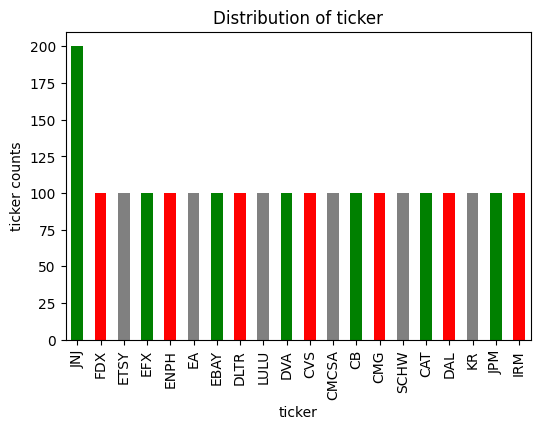

In [14]:
ticker_counts = df['ticker'].value_counts()

# Plot top 20 ticker counts
top_20 = ticker_counts.head(20)
#distribution of ticker 
claimLabel_counts = df['ticker'].value_counts()
plt.figure(figsize=(6,4))
top_20.plot(kind='bar',color =['green','red','gray'])
plt.title('Distribution of ticker')
plt.xlabel('ticker')
plt.ylabel('ticker counts')
plt.show()

This indicates that the ticker values are uniform, demonstrating the balanced financial information available for the different companies, except for JNJ, which is 200.

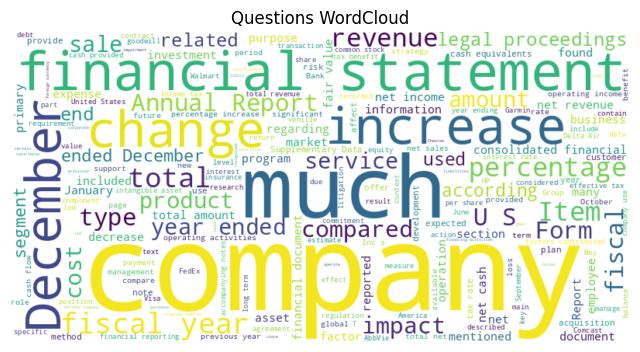

In [15]:
#word cloud for questions

#joins all questions strings into one string and removes all missing values
question = "".join(df['question'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Questions WordCloud')
plt.show()

This word cloud clearly shows that the words are appearing more in this dataset and we can see  company, financial statement,increase, and percentage. This is mainly because the data is financial report of companies.

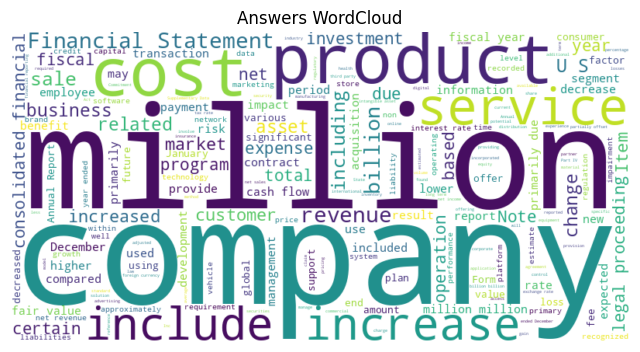

In [16]:
#word cloud for answers

#joins all answer strings into one string and removes all missing values
answer = "".join(df['answer'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(answer)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Answers WordCloud')
plt.show()

On this answers word cloud too, we can see the appearance of finance terms like product service, market, asset ,loss , service and etc.

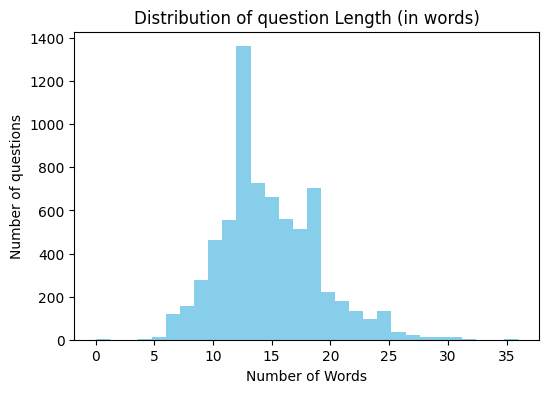

In [17]:
#Distribution of question Length in words

#Length of each qustion in number of words
question_lengths = df['question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
plt.hist(question_lengths, bins=30, color='skyblue')
plt.title('Distribution of question Length (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of questions')
plt.show()


This plot shows that the number of words in the questions generally range between 5 to 30 words

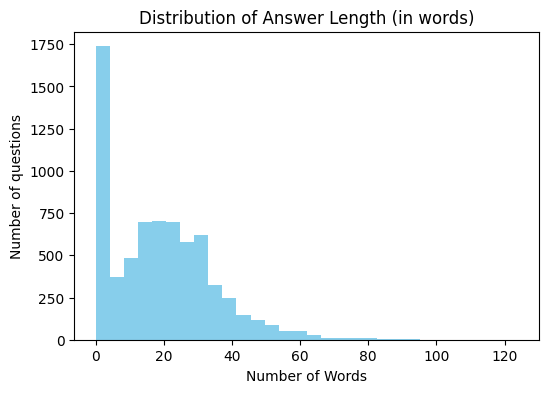

In [18]:
#Distribution of answers Length in words

#Length of each answer in number of words
answer_lengths = df['answer'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
plt.hist(answer_lengths, bins=30, color='skyblue')
plt.title('Distribution of Answer Length (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of questions')
plt.show()


This plot shows that the number of words in the answers generally ranges between 5 to 60 words

In [19]:
# Preprocess training data: combine ticker, filing, QA into single text field
# for causal language modeling input format
def format_row(row):
    ticker = row.get('ticker', '')
    filing = row.get('filing', '')
    question = row['question'].strip()
    answer = row['answer'].strip()
    return f"Ticker: {ticker} Filing: {filing} Q: {question} A: {answer}"

df['text'] = df.apply(format_row, axis=1)

In [20]:
print(df['text'].sample(5).values)

['Ticker: AAPL Filing: 2023_10K Q: What did Masimo allege in its complaint before the U.S. International Trade Commission? A: Masimo alleged that Apple infringed on five patents related to the functionality of the blood oxygen feature in Apple Watch Series 6 and 7.'
 "Ticker: T Filing: 2023_10K Q: What is the location of AT&T Inc.'s principal executive offices? A: The principal executive offices of AT&T Inc. are located at 208 S. Akard St., Dallas, Texas, 75202."
 'Ticker: ETSY Filing: 2023_10K Q: How does Etsy generate revenue? A: Etsy generates revenue primarily from marketplace activities, including transaction fees, payments processing, and listing fees, as well as from optional seller services such as on-site advertising and shipping labels.'
 'Ticker: BAC Filing: 2023_10K Q: What was the allowance for loan and lease losses at Bank of America as of December 31, 2022? A: $12,682 million'
 'Ticker: GOOGL Filing: 2023_10K Q: As of December 31, 2023, what is the total balance of acqui

In [21]:
#text normalisation
import re
def normalize_text(text):
    # changes text to Lowercase
    text = text.lower()
    # Removes punctuation (keep only alphanumeric and whitespace)
    text = re.sub(r"[^\w\s]", "", text)
    # Removes extra whitespace
    text = " ".join(text.split())
    return text

In [22]:
# Split dataset into train and validation sets and convert to HuggingFace format
train_df, val_df = train_test_split(df[['text']], test_size=0.1, random_state=42)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 6300
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 700
    })
})

In [24]:
# Initialize GPT-2 tokenizer and configure padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token 

# Tokenize dataset with fixed sequence length for consistent batch processing
def tokenize_function(examples):
  return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=200)
tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [25]:
# Compute token lengths before padding
token_lengths = [len(tokenizer.encode(text)) for text in dataset['train']['text']]

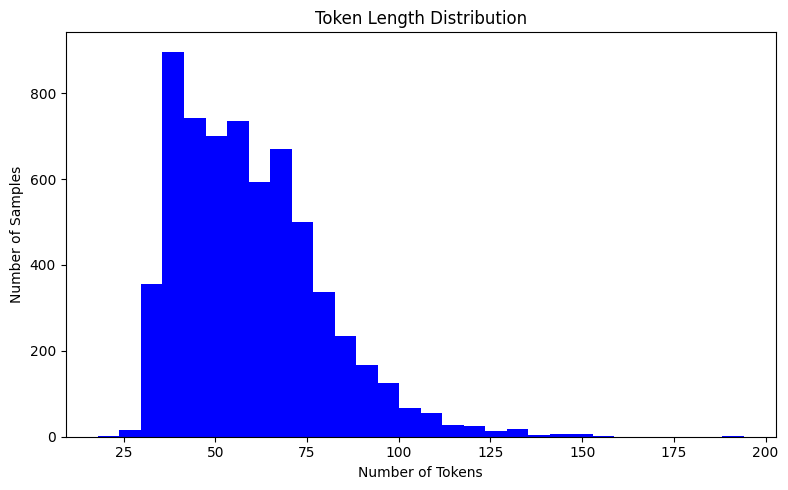

Max tokens: 194
Average tokens: 59.66


In [26]:
#plotting token length distrubution
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=30, color='blue')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Samples')
plt.grid(False)
plt.tight_layout()
plt.show()

print(f"Max tokens: {max(token_lengths)}")
print(f"Average tokens: {sum(token_lengths) / len(token_lengths):.2f}")

In [27]:
# Convert HuggingFace dataset to TensorFlow format for model training
# Labels are set to input_ids for causal language modeling (next token prediction)
def convert_to_tf(ds, shuffle=True, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tf.constant(ds["input_ids"]),
            "attention_mask": tf.constant(ds["attention_mask"]),
        },
        tf.constant(ds["input_ids"])  
    ))
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size)
    
# Create TensorFlow datasets: shuffle training data, keep validation ordered
tf_train = convert_to_tf(tokenized_dataset["train"], shuffle=True, batch_size=4)
tf_val = convert_to_tf(tokenized_dataset["validation"], shuffle=False, batch_size=4)

I0000 00:00:1750616115.636805      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750616115.637598      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [28]:
#initialising the model
model = TFGPT2LMHeadModel.from_pretrained("gpt2")

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [29]:
# Setup optimizer and learning rate scheduler
num_epochs = 5
batch_size = 4
total_train_steps = (len(tf_train) * num_epochs)
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

model.compile(optimizer=optimizer)

In [30]:
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=num_epochs,
)

Epoch 1/5


I0000 00:00:1750616194.608397     100 service.cc:148] XLA service 0x79a7b42f2300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750616194.613127     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750616194.613150     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750616194.790421     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750616195.036655     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1575/1575 [==============================] - 1199s 732ms/step - loss: 0.2775 - val_loss: 0.2241
Epoch 2/5
1575/1575 [==============================] - 1150s 730ms/step - loss: 0.2178 - val_loss: 0.2164
Epoch 3/5
1575/1575 [==============================] - 1150s 730ms/step - loss: 0.2050 - val_loss: 0.2128
Epoch 4/5
1575/1575 [==============================] - 1150s 730ms/step - loss: 0.1963 - val_loss: 0.2111
Epoch 5/5
1575/1575 [==============================] - 1150s 730ms/step - loss: 0.1911 - val_loss: 0.2109


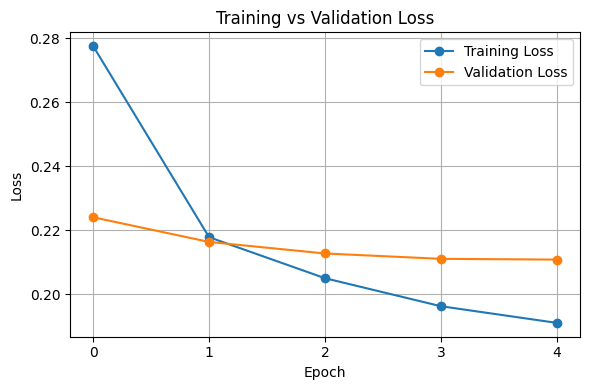

In [31]:
# Function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(len(history.history['loss'])))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot history
plot_loss(history)


In [32]:
#saving the model
model.save_pretrained("./financialqa_model")

# Saving tokenizer
tokenizer.save_pretrained("./financialqa_model")

('./financialqa_model/tokenizer_config.json',
 './financialqa_model/special_tokens_map.json',
 './financialqa_model/vocab.json',
 './financialqa_model/merges.txt',
 './financialqa_model/added_tokens.json')

In [33]:
pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [34]:
from huggingface_hub import login
login()


In [37]:
# Loading the saved GPT-2 model
model = TFGPT2LMHeadModel.from_pretrained("./financialqa_model")

# Loading the corresponding tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("./financialqa_model")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 needs a pad token set manually


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./financialqa_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [38]:
model.push_to_hub("financeQA_chatbot")
tokenizer.push_to_hub("financeQA_chatbot")

tf_model.h5:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/896 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Awinpang/financeQA_chatbot/commit/bcc9e4d108be1b9c63a725ec7b1d921c7ac1e0e5', commit_message='Upload tokenizer', commit_description='', oid='bcc9e4d108be1b9c63a725ec7b1d921c7ac1e0e5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Awinpang/financeQA_chatbot', endpoint='https://huggingface.co', repo_type='model', repo_id='Awinpang/financeQA_chatbot'), pr_revision=None, pr_num=None)

In [39]:
# List of prompts (questions) to generate the answers
prompts = [
    "Q: What is the role of cryptocurrency in modern finance?\nA:",
    "Q: Why is the stock market affected by inflation?\nA:",
    "Q: Define what a stock means in simple terms.\nA:",
    "Q: What are the benefits of investing in bonds?\nA:",
    "Q: How does interest rate affect loan repayments?\nA:"
]

for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="tf")
    
    output = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    answer = decoded.split("A:")[-1].strip()
    
    # Remove trailing 'A:' from prompt before printing
    prompt_clean = prompt.rstrip("A:").rstrip()
    
    print(f"{prompt_clean}\nA: {answer}\n")

Q: What is the role of cryptocurrency in modern finance?
A: Digital currencies are used to facilitate transactions, facilitate payments, and facilitate the exchange of goods and services. They are regulated by the U.S. Securities and Exchange Commission (SEC).

Q: Why is the stock market affected by inflation?
A: The inflationary impact of inflation is primarily due to the increase in interest rates on the U.S. dollar, which is partially offset by a decrease in foreign currency exchange rates.

Q: Define what a stock means in simple terms.
A: A stock refers to a company's financial condition and results of operations.

Q: What are the benefits of investing in bonds?
A: Bonds are a diversified portfolio of assets that can be leveraged for long-term returns. They can also be used to invest in other assets, such as real estate, property, and equipment.

Q: How does interest rate affect loan repayments?
A: Interest rate is influenced by factors such as interest rates, the timing of interes

In [43]:
#Compute perplexity score
def compute_perplexity(model, dataset):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    total_loss = 0.0
    total_tokens = 0

    for inputs, labels in dataset:
        logits = model(inputs, training=False).logits
        loss = loss_object(labels, logits)

        total_loss += tf.reduce_sum(loss)
        total_tokens += tf.reduce_sum(tf.ones_like(labels, dtype=tf.float32))

    if total_tokens == 0:
        return float("inf")

    perplexity = tf.exp(total_loss / total_tokens)
    return perplexity.numpy()

In [44]:
#print the perplexity score
perplexity_score = compute_perplexity(model, tf_val)
print("Perplexity:", perplexity_score)

Perplexity: 5.8956943


In [45]:
!pip install bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [46]:
from bert_score import score
import re

# Text normalization
def normalize_text(text):
    text = text.lower()  
    text = re.sub(r"[^\w\s]", "", text)  
    text = " ".join(text.split())  
    return text

# Evaluate GPT-2 using BERTScore with normalization
def evaluate_gpt2_bertscore(model, tokenizer, prompts, references):
    predictions = []

    for prompt in prompts:
        input_ids = tokenizer(prompt, return_tensors="tf").input_ids
        output = model.generate(
            input_ids,
            max_length=60,
            temperature=0.9,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True  
        )
        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(decoded)

    # Normalize both predictions and references
    normalized_preds = [normalize_text(p) for p in predictions]
    normalized_refs = [normalize_text(r) for r in references]

    # Compute BERTScore
    _, _, bert_f1s = score(normalized_preds, normalized_refs, lang="en", verbose=False)
    bert_avg = bert_f1s.mean().item()

    # Print results
    for i, (p, r, b) in enumerate(zip(predictions, references, bert_f1s)):
        print(f"Prompt: {prompts[i]}")
        print(f"Reference: {r}")
        print(f"Prediction: {p}")
        print(f"BERTScore-F1: {round(b.item(), 4)}\n")

    print("Average BERTScore:", round(bert_avg, 4))
    return predictions


In [47]:
prompts = [
    "Explain why the stock market is volatile.",
    "What is cryptocurrency?",
    "What does a stock represent?"
]

references = [
    "The stock market is experiencing volatility due to inflation concerns.",
    "Cryptocurrency is a digital or virtual currency secured by cryptography.",
    "A stock represents ownership in a company and a claim on its assets and earnings."
]


evaluate_gpt2_bertscore(model, tokenizer,prompts,references)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt: Explain why the stock market is volatile.
Reference: The stock market is experiencing volatility due to inflation concerns.
Prediction: Explain why the stock market is volatile.
BERTScore-F1: 0.9005

Prompt: What is cryptocurrency?
Reference: Cryptocurrency is a digital or virtual currency secured by cryptography.
Prediction: What is cryptocurrency? The blockchain platform provides value to the company through a variety of transaction mechanisms, including decentralized peer-toicker networks and distributed data stores.
BERTScore-F1: 0.8418

Prompt: What does a stock represent?
Reference: A stock represents ownership in a company and a claim on its assets and earnings.
Prediction: What does a stock represent?
BERTScore-F1: 0.8426

Average BERTScore: 0.8616


['Explain why the stock market is volatile.',
 'What is cryptocurrency? The blockchain platform provides value to the company through a variety of transaction mechanisms, including decentralized peer-toicker networks and distributed data stores.',
 'What does a stock represent?']